In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cross_validation as CV
from sklearn.feature_extraction import DictVectorizer as DV
from datetime import date
from sklearn import linear_model as LM
from sklearn.ensemble import GradientBoostingRegressor as GBR

%matplotlib inline

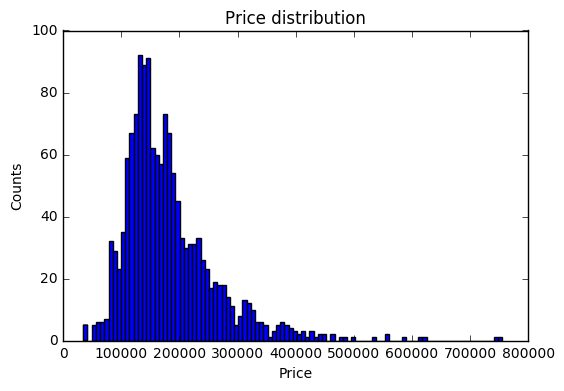

In [10]:
data = pd.read_csv('train.csv',index_col='Id')
features = data.drop('SalePrice',axis = 1)
price = data.SalePrice
plt.hist(price,bins = 100)
plt.xlabel('Price')
plt.ylabel('Counts')
plt.title('Price distribution')
plt.show()

## Define functions

In [75]:
def myScore(y, y_pred):
    res = np.ndarray([1,2]);
    u = (np.power((y-y_pred),2)).sum();
    v = (np.power((y-y.mean()),2)).sum();
    res[0,0] = 1-(u/v);

    
    yLog = np.log(y);
    ind = np.isinf(yLog);
    yLog[ind == True] = 0; 
    y_predLog = np.log(y_pred);
    ind = np.isinf(y_predLog);
    y_predLog[ind == True] = 0;   
    summ = np.sum(np.power(yLog-y_predLog,2))
    res[0,1] = np.sqrt(summ/y.shape[0]);

    return res

# replace qualitative estimation to number
def replaceQualVal(dataSet,fNameList):
    # dictionary of values
    vocab = {
        'Ex': 5, 'EX': 5, # excellent    
        'Gd': 4, 'GD': 4, # good
        'TA': 3, 'Ta': 3, # normal
        'FA': 2, 'Fa': 2, # fair
        'PO': 1, 'Po': 1  # 
        }
    
    for fName in fNameList:
        # replace stings to numbers
        for word in vocab:
            searchDict = {fName:[word]};
            X = dataSet.isin(searchDict);
            dataSet.loc[X[fName],fName] = vocab[word];
        
        # convert to numeric type
        dataSet[[fName]] = dataSet[[fName]].apply(pd.to_numeric);
    return dataSet;    
# end of function

# replace Yes/No estimation to number
def replaceYNVal(dataSet,fNameList):
    # dictionary of values
    vocab = {
        'Y': 1, 'Yes': 1, # yes    
        'N': 0, 'No': 0 # no
        }
    
    for fName in fNameList:
        # replace stings to numbers
        for word in vocab:
            searchDict = {fName:[word]};
            X = dataSet.isin(searchDict);
            dataSet.loc[X[fName],fName] = vocab[word];
        
        # convert to numeric type
        dataSet[[fName]] = dataSet[[fName]].apply(pd.to_numeric);
    return dataSet; 

## Create folds and trees 

In [85]:
features = data.drop('SalePrice',axis = 1)
price = data['SalePrice'].get_values()

features["OverallQualLog"]=np.log(features["OverallQual"])
features.drop(['OverallQual'],axis = 1,inplace = True);

# drop heating type
features.drop('Heating',axis = 1,inplace = True);
features.drop(['MoSold', 'YrSold'],axis = 1,inplace = True);


featureList = {'ExterQual','ExterCond','BsmtQual','BsmtCond','PoolQC','HeatingQC','KitchenQual','GarageQual',
               'GarageCond','FireplaceQu','PoolQC'};

features = replaceQualVal(features,featureList)

num_features = features.select_dtypes(exclude=['object']);

# process GarageYrBlt
empty = pd.isnull(num_features['GarageYrBlt']);
ind = empty[empty == True].index;
num_features.loc[ind.values,'GarageYrBlt'] = features.loc[ind.values,'YearBuilt'];

# add new feature
num_features.loc[:,'houseAgeLog'] = np.log(date.today().year - num_features.loc[:,'YearBuilt']);
num_features.loc[:,'garageAgeLog'] = np.log(date.today().year - num_features.loc[:,'GarageYrBlt']);
num_features.loc[:,'remodeAge'] = num_features.loc[:,'YearRemodAdd'] - num_features.loc[:,'YearBuilt'];
num_features.fillna(0,inplace=True);

obj_features = features.select_dtypes(include=['object']);
obj_features.fillna('empty',inplace=True)
encoded_data = encoder.fit_transform(obj_features.T.to_dict().values());
transFeatures = np.hstack([num_features, encoded_data]);

In [86]:
trees = GBR(verbose = 0, n_estimators = 1000, max_depth = 3);

nFolds = 7;
folds = CV.KFold(price.size, n_folds=nFolds, random_state = 43);

In [87]:
score = np.empty([1,2]);

for [trainInds, testInds] in folds:
    trees.fit(transFeatures[trainInds,:],price[trainInds]);
    y_pr = trees.predict(transFeatures[testInds,:]);
    score =  np.append(score,myScore(price[testInds],y_pr),axis = 0);

score = np.delete(score,0,0);
print score.mean(0)

[ 0.89871343  0.12471121]


In [15]:
features = data.drop('SalePrice',axis = 1)
price = data['SalePrice'].get_values()

#features["OverallQualLog"]=np.log(features["OverallQual"])
#features.drop(['OverallQual'],axis = 1,inplace = True);

# drop heating type
#features.drop('Heating',axis = 1,inplace = True);
#features.drop(['MoSold', 'YrSold'],axis = 1,inplace = True);


#featureList = {'ExterQual','ExterCond','BsmtQual','BsmtCond','PoolQC','HeatingQC','KitchenQual','GarageQual',
#               'GarageCond','FireplaceQu','PoolQC'};

#features = replaceQualVal(features,featureList)

num_features = features.select_dtypes(exclude=['object']);

# process GarageYrBlt
empty = pd.isnull(num_features['GarageYrBlt']);
ind = empty[empty == True].index;
num_features.loc[ind.values,'GarageYrBlt'] = features.loc[ind.values,'YearBuilt'];

# add new feature
num_features.loc[:,'houseAgeLog'] = np.log(date.today().year - num_features.loc[:,'YearBuilt']);
num_features.loc[:,'garageAgeLog'] = np.log(date.today().year - num_features.loc[:,'GarageYrBlt']);
num_features.loc[:,'remodeAge'] = num_features.loc[:,'YearRemodAdd'] - num_features.loc[:,'YearBuilt'];
num_features.fillna(0,inplace=True);

obj_features = features.select_dtypes(include=['object']);
obj_features.fillna('empty',inplace=True)
encoded_data = encoder.fit_transform(obj_features.T.to_dict().values());
transFeatures = np.hstack([num_features, encoded_data]);

score = np.empty([1,2]);

for [trainInds, testInds] in folds:
    trees.fit(transFeatures[trainInds,:],price[trainInds]);
    y_pr = trees.predict(transFeatures[testInds,:]);
    score =  np.append(score,myScore(price[testInds],y_pr),axis = 0);

score = np.delete(score,0,0);
print score.mean(0)

[ 0.89532533  0.12600869]


In [16]:
features = data.drop('SalePrice',axis = 1)
price = data['SalePrice'].get_values()

features["OverallQualLog"]=np.log(features["OverallQual"])
features.drop(['OverallQual'],axis = 1,inplace = True);

# drop heating type
#features.drop('Heating',axis = 1,inplace = True);
#features.drop(['MoSold', 'YrSold'],axis = 1,inplace = True);


#featureList = {'ExterQual','ExterCond','BsmtQual','BsmtCond','PoolQC','HeatingQC','KitchenQual','GarageQual',
#               'GarageCond','FireplaceQu','PoolQC'};

#features = replaceQualVal(features,featureList)

num_features = features.select_dtypes(exclude=['object']);

# process GarageYrBlt
empty = pd.isnull(num_features['GarageYrBlt']);
ind = empty[empty == True].index;
num_features.loc[ind.values,'GarageYrBlt'] = features.loc[ind.values,'YearBuilt'];

# add new feature
num_features.loc[:,'houseAgeLog'] = np.log(date.today().year - num_features.loc[:,'YearBuilt']);
num_features.loc[:,'garageAgeLog'] = np.log(date.today().year - num_features.loc[:,'GarageYrBlt']);
num_features.loc[:,'remodeAge'] = num_features.loc[:,'YearRemodAdd'] - num_features.loc[:,'YearBuilt'];
num_features.fillna(0,inplace=True);

obj_features = features.select_dtypes(include=['object']);
obj_features.fillna('empty',inplace=True)
encoded_data = encoder.fit_transform(obj_features.T.to_dict().values());
transFeatures = np.hstack([num_features, encoded_data]);

trees = GBR(verbose = 0, n_estimators = 1000, max_depth = 3);

for [trainInds, testInds] in folds:
    trees.fit(transFeatures[trainInds,:],price[trainInds]);
    y_pr = trees.predict(transFeatures[testInds,:]);
    score =  np.append(score,myScore(price[testInds],y_pr),axis = 0);

score = np.delete(score,0,0);
print score.mean(0)

[ 0.89295458  0.12593607]


In [24]:
features = data.drop('SalePrice',axis = 1)
price = data['SalePrice'].get_values()

features["OverallQualLog"]=np.log(features["OverallQual"])
features.drop(['OverallQual'],axis = 1,inplace = True);

# drop heating type
features.drop('Heating',axis = 1,inplace = True);
#features.drop(['MoSold', 'YrSold'],axis = 1,inplace = True);


featureList = {'ExterQual','ExterCond','BsmtQual','BsmtCond','PoolQC','HeatingQC','KitchenQual','GarageQual',
               'GarageCond','FireplaceQu','PoolQC'};

features = replaceQualVal(features,featureList)

num_features = features.select_dtypes(exclude=['object']);

# process GarageYrBlt
empty = pd.isnull(num_features['GarageYrBlt']);
ind = empty[empty == True].index;
num_features.loc[ind.values,'GarageYrBlt'] = features.loc[ind.values,'YearBuilt'];

# add new feature
num_features.loc[:,'houseAgeLog'] = np.log(date.today().year - num_features.loc[:,'YearBuilt']);
num_features.loc[:,'garageAgeLog'] = np.log(date.today().year - num_features.loc[:,'GarageYrBlt']);
num_features.loc[:,'remodeAge'] = num_features.loc[:,'YearRemodAdd'] - num_features.loc[:,'YearBuilt'];
num_features.fillna(0,inplace=True);

obj_features = features.select_dtypes(include=['object']);
obj_features.fillna('empty',inplace=True)
encoded_data = encoder.fit_transform(obj_features.T.to_dict().values());
transFeatures = np.hstack([num_features, encoded_data]);

score = np.empty([1,2]);

for [trainInds, testInds] in folds:
    trees.fit(transFeatures[trainInds,:],price[trainInds]);
    y_pr = trees.predict(transFeatures[testInds,:]);
    score =  np.append(score,myScore(price[testInds],y_pr),axis = 0);

score = np.delete(score,0,0);
print score.mean(0)

GarageCond
BsmtCond
HeatingQC
GarageQual
ExterCond
ExterQual
FireplaceQu
KitchenQual
BsmtQual
PoolQC
[ 0.8980913   0.12551593]


In [84]:
features = data.drop('SalePrice',axis = 1)
price = data['SalePrice'].get_values()

features["OverallQualLog"]=np.log(features["OverallQual"])
features.drop(['OverallQual'],axis = 1,inplace = True);

# drop heating type
features.drop('Heating',axis = 1,inplace = True);
#features.drop(['MoSold', 'YrSold'],axis = 1,inplace = True);
features.drop(['PoolQC','PoolArea'],axis = 1,inplace = True);

# replace qualitative values
featureList = {'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','GarageQual',
               'GarageCond','FireplaceQu'};
#features = replaceQualVal(features,featureList);

# replace Yes/No values
#features = replaceYNVal(features, {'CentralAir'});


numFeatureNames = features.select_dtypes(exclude=['object']).columns;
numFeatureNames = numFeatureNames.drop({'MSSubClass'});
num_features = features.loc[:,numFeatureNames];

# process GarageYrBlt
empty = pd.isnull(num_features['GarageYrBlt']);
ind = empty[empty == True].index;
num_features.loc[ind.values,'GarageYrBlt'] = features.loc[ind.values,'YearBuilt'];

# add new feature
num_features.loc[:,'houseAgeLog'] = np.log(date.today().year - num_features.loc[:,'YearBuilt']);
num_features.loc[:,'garageAgeLog'] = np.log(date.today().year - num_features.loc[:,'GarageYrBlt']);
num_features.loc[:,'remodeAge'] = num_features.loc[:,'YearRemodAdd'] - num_features.loc[:,'YearBuilt'];
num_features.fillna(0,inplace=True);


objFeatureNames = features.select_dtypes(include=['object']).columns; 
obj_features = features.loc[:,np.append(objFeatureNames.values, 'MSSubClass')]
obj_features.fillna('empty',inplace=True)
encoded_data = encoder.fit_transform(obj_features.T.to_dict().values());
transFeatures = np.hstack([num_features, encoded_data]);

score = np.empty([1,2]);

for [trainInds, testInds] in folds:
    trees.fit(transFeatures[trainInds,:],price[trainInds]);
    y_pr = trees.predict(transFeatures[testInds,:]);
    score =  np.append(score,myScore(price[testInds],y_pr),axis = 0);

score = np.delete(score,0,0);
print score.mean(0)

[ 0.89630042  0.12493057]
